# Students team: Otniel Elkayam, Shaul Chamola
_Department of Data Mining, Jerusalem College of Technology_  
__Targil 2__

In [4]:
import sys
from search_yt import YT_searcher, download_mp4
from title_filter import get_best_parts, build_plots
from title_builder import build_subtitles
from concatenate_clips import make_clip

# step 1

In [7]:
search_sentence = 'how to smile'
print('Searching:', search_sentence)

YT = YT_searcher()
MAX_VIDEOS_TO_PARSE = 2

# This library uses native YouTube search.
# Instead of searching, you can download the text of the video by ID:
# df_subtitles = YT.download_subtitles(id)
ids, df_subtitles = YT.search(search_sentence, MAX_VIDEOS_TO_PARSE)

print('Videos found:', len(ids))

Searching: how to smile
Videos found: 2


# step 2

## function "build_subtitles" step by step

In [14]:
import pandas as pd
import re
import numpy as np
from spacy.lang.en import English
nlp = English()

from ngrams import Word_Frequency
ngrams = Word_Frequency()

Ngrams base loaded. Words in base: 3815


In [21]:
# input params
text = [list(df['text']) for df in df_subtitles]
window = 100 
max_words = 7
parse_text_parts = True

if type(text) == str:
    text = [text]

### Cleaning data

In [12]:
def clear_text(text):
    text_part = text.replace('\n', ' ').replace('\t', '').replace('[', ' ').replace(']', ' ')
    text_part = re.sub('[,\.!?><"]', '', text_part)
    text_part = re.sub('[_-]', ' ', text_part)
    text_part = re.sub('(\s){2,8}', ' ', text_part)
    text_part = text_part.rstrip().lstrip()
    # Convert the titles to lowercase
    return text_part.lower()

### Part of input text:

In [24]:
text[0][:4]

["Don't you hate when you're going through\npictures of yourself and you're just",
 'like "what, that\'s so weird smile"\nEspecially old pictures, well that\'s',
 "probably because it is weird. But hey,\nthat's not your faul,t it's not your",
 "problem. Believe it or not that's a common problem, thats"]

In [25]:
# Remove punctuation
# Remove punctuation and punctuation marks. The tokenizer will give a better result
print('\rRemoving punctuation. part 1 of 6', end=' '*10)
text_parts = []
text_parts_num = []
for t in range(len(text)):
    if type(text[t]) == list:
        if not parse_text_parts:
            text[t] = ' '.join(text[t])
            text[t] = clear_text(text[t])
        else:       # if not parse_text_parts
            text_part_num = [0]
            text_part = []
            accumulate = 0
            text_doc = ''
            for part in range(len(text[t])):
                text[t][part] = clear_text(text[t][part])
                tt = text[t][part].split(' ')
                tt_set = set(tt)
                while '' in tt_set:
                    tt.remove('')
                    tt_set = set(tt)
                lenght_part = len(tt)
                accumulate += lenght_part
                text_part_num.append(accumulate)
                text_part.extend([part for _ in range(lenght_part)])
                text_doc = text_doc + ' ' + ' '.join(tt)

            text[t] = text_doc[1:]
    if parse_text_parts:
        text_parts.append(text_part)
        text_parts_num.append(text_part_num[:-1])
        del(text_part, text_part_num, text_doc)

Removing punctuation. part 1 of 6          

### Text after cleaning:

In [26]:
text[0][:400]

"don't you hate when you're going through pictures of yourself and you're just like what that's so weird smile especially old pictures well that's probably because it is weird but hey that's not your fault it's not your problem believe it or not that's a common problem thats a lot of guys face i faced it myself so in today's video i'm gonna show you how to avoid that awkward ugly weird smile and ma"

### Building dictionary of words

In [27]:
# dictionary
# Create a bag of words and count them
print('\rBuilding dictionary of words. part 2 of 6', end=' '*10)
docs = []
for doc in text:
    tt = doc.split(' ')
    tt_set = set(tt)
    while '' in tt_set:
        tt.remove('')
        tt_set = set(tt)
    docs.append(tt)
del(tt, text)

dict_words = dict()
doc_words = []
for doc in docs:
    num_words = 0
    for word in doc:
        # if not len(word) > 0:
        #     continue
        if word in dict_words:
            dict_words[word] += 1
        else:
            dict_words[word] = 1
        num_words += 1
    doc_words.append(num_words)

Building dictionary of words. part 2 of 6          

### Dictionary

In [47]:
for w in list(dict_words.keys())[:10]: print(f'{w}:{dict_words[w]}')

don't:10
you:107
hate:1
when:26
you're:32
going:10
through:1
pictures:3
of:44
yourself:2


### building frequencies
For each word in the dictionary and load its frequency from the ngrams server.  
If an error occurs and the download fails, then the word frequency among all documents is sent.  
The ngrams downloader has a SQLite database and first checks if there are these words in the database,  
if not, then it parses the Google site.  

In [45]:
print('\rCalculating frequencies of words. part 3 of 6', end=' '*10)
total_words = sum(doc_words)
dict_freq = dict()
ngrams_freqs = ngrams.get_frequency(dict_words.keys())
for i, key in enumerate(dict_words.keys()):
    if ngrams_freqs[i] == 0:
        dict_freq[key] = dict_words[key] / total_words
    else:
        dict_freq[key] = ngrams_freqs[i]

Parsing ngrams frequencies words. part 3 of 6          
 Done                9


### Dictionary of frequencies

In [57]:
for w in list(dict_freq.keys())[:10]: print(f'{w:10s}: {dict_freq[w]:.5f}')

don't     : 0.00038
you       : 0.00192
hate      : 0.00001
when      : 0.00095
you're    : 0.00006
going     : 0.00020
through   : 0.00064
pictures  : 0.00003
of        : 0.02945
yourself  : 0.00004


### accumulative table
for row to word conversion and backwards (Word2Vect)

In [62]:
word2row = dict()
row2word = dict()
# Frequencies from ngrams
array_freqs = np.zeros((len(dict_words)))
for i,word in enumerate(sorted(dict_words.keys())):
    word2row[word] = i
    row2word[i] = word
    array_freqs[i] = dict_freq[word]

### Table of word appearance in text

In [64]:
# [num docs, word, possition in doc] => (0,1)
# Where word appears in the word possitions in documents. axis X - words, axis Y - possition in document
print('\rTable word appearance. part 4 of 6', end=' '*10)
table_appearance = [np.zeros((len(dict_words), doc_len)) for doc_len in doc_words]
for d,doc in enumerate(docs):
    possition = 0
    for word in doc:
        table_appearance[d][word2row[word], possition] += 1
        possition += 1

Table word appearance. part 4 of 6          

### Table word appearance: 
>__rows__ - word; __columns__ - place in the text

In [80]:
ta = pd.DataFrame(table_appearance[0])
ta['word'] = word2row.keys()
ta

,0,1,2,3,4,5,6,7,8,9,...,1188,1189,1190,1191,1192,1193,1194,1195,1196,word
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100%
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,you
655,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,you're
656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,you've
657,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,your


### How much times word appears in the window of words in text
To divide the document into parts, we count TF IDF in the interval of 100 words (window)  
to understand which words are key at a given interval

In [88]:
print(f'\rTable word appearance frequency in window({window}). part 5 of 6', end=' '*4)
table_appearance_freq = [np.zeros((table.shape[0], table.shape[1])) for table in table_appearance]
mean_freq_inverted = []
for d, table in enumerate(table_appearance):
    half = window // 2
    end = table.shape[1] - 1
    for i in range(table.shape[1]):
        # Inverse Document Frequency
        IDF = (table[:, max(0, i - half):min(end, i + half)].sum(axis=1) / window) / array_freqs
        IDF_bm = 5*IDF/(IDF+4)  #BM25 transformation, k = 4
        table_appearance_freq[d][:,i] = IDF_bm
        mean_freq_inverted.append(np.mean(IDF_bm))
mean_freq_inverted = np.mean(mean_freq_inverted)

Table word appearance frequency in window(100). part 5 of 6    

### Table word appearance frequency : 
>__rows__ - word; __columns__ - place in the text; __value__ - inverted frequency

In [87]:
taf = pd.DataFrame(table_appearance_freq[0].round(3))
taf['word'] = word2row.keys()
taf

,0,1,2,3,4,5,6,7,8,9,...,1188,1189,1190,1191,1192,1193,1194,1195,1196,word
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,100%
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,12
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,15
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654,2.829,2.829,2.829,2.829,2.829,2.829,2.829,2.829,2.829,2.829,...,3.613,3.613,3.613,3.613,3.613,3.613,3.613,3.613,3.613,you
655,4.943,4.943,4.943,4.943,4.943,4.943,4.943,4.943,4.943,4.943,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,you're
656,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,4.960,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,you've
657,4.376,4.376,4.376,4.376,4.376,4.376,4.376,4.376,4.376,4.376,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,your


### Choising best words
>At each step of the segment, we take an estimate of the frequency of the n-th word (after sorting),  
where n is the number of words that we want to take for the title. We get the minimum frequency for n words.  
So we take the average estimate of the frequency of words in the document and choose the maximum of these two values.  
It turns out at each step we get up to n words with the maximum score for this step.  

In [89]:
data = [{'app_freq':0, 'app_freq_f':0, 'most_app':0, 'most_words':0} for _ in range(len(docs))]
print('\rTable word most appearance in window. part 6 of 6', end=' '*10)
for i,table in enumerate(table_appearance_freq):
    dataset = pd.DataFrame(table.T, columns=word2row.keys())
    # dataset.to_csv(f'result_words_{i}.csv', index=None)
    data[i]['app_freq'] = dataset

    # dataset with One Hot encoding for most frequent words
    dataset_filtered = dataset.copy(True)
    for j in range(dataset_filtered.shape[0]):
        limit = sorted(dataset_filtered.loc[j], reverse=True)[max_words] # taking frequency of last frequent word
        limit = max(limit, mean_freq_inverted)
        dataset_filtered.loc[j] = dataset_filtered.loc[j].mask(dataset_filtered.loc[j] < limit, 0)
    data[i]['app_freq_f'] = dataset_filtered.fillna(0)

Table word most appearance in window. part 6 of 6          

### Filtered table of frequencies
>__index__ - word; __columns__ - possition in text

In [94]:
data[0]['app_freq_f'].T.round(3)

,0,1,2,3,4,5,6,7,8,9,...,1187,1188,1189,1190,1191,1192,1193,1194,1195,1196
100%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
you,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
you're,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
you've,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.96,4.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
your,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Adding placement of word in video

In [95]:
if parse_text_parts:
    for i in range(len(data)):
        data[i]['text_part'] = text_parts[i]
        data[i]['text_part_pos'] = text_parts_num[i]

__number__ - part of video

In [100]:
data[0]['text_part'][:25]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]

# step 3

## function "get_best_parts" step by step

In [102]:
import spacy
nlp = spacy.load('en_core_web_lg')
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
plt.style.use('seaborn')

In [105]:
# inputs
data = data
query = search_sentence
yt_subtitles = df_subtitles
docs_num = len(data)

### kmeans labels
At the input, the classifier receives a table of n words with the highest score. The rest of the words are rated 0.  
Thus we divide the text into several parts according to their subject matter

In [108]:
def _knn_mean(arr, n=20):
    half = n // 2
    end = len(arr) - 1
    mean = []
    for n in range(len(arr)):
        labels, counts = np.unique(arr[max(0, n-half): min(end, n+half)], return_counts=True)
        mean.append(labels[np.argmax(counts)])
    return np.array(mean)

print('\rkmeans labels. part 1 of 4', end=' ' * 35)
kmeans_labels = []
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
for i in range(docs_num):
    # print('len', data[i]['app_freq_f'].shape)
    kmeans.fit(data[i]['app_freq_f'])  # .mask(data[0]['app_freq_f'] > 0, 1))
    labels = kmeans.labels_
    kmeans_labels.append(labels)
    data[i]['labels'] = labels

kmeans labels. part 1 of 4                                   

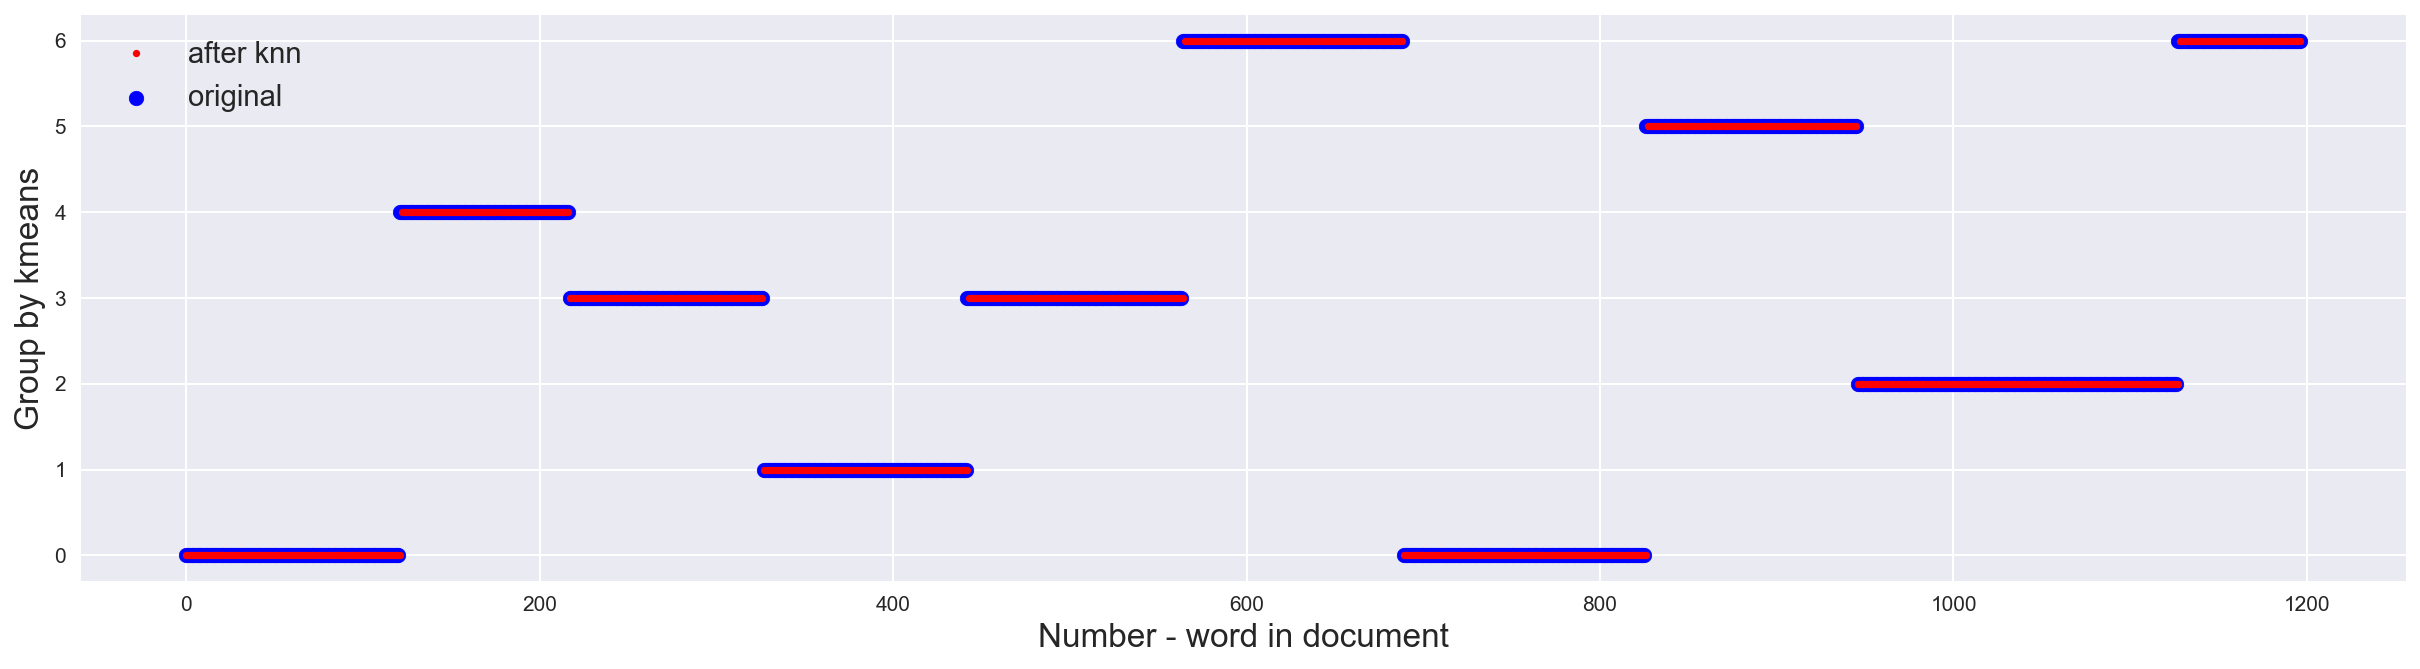

In [198]:
fig = plt.figure(figsize=(20, 5), dpi=150)
plt.scatter(x=range(data[0]['app_freq_f'].shape[0]), y=data[0]['labels'], color='b', label='original')
plt.plot(_knn_mean(data[0]['labels'], 40), 'r.', label='after knn')
plt.xlabel('Number - word in document', fontsize=16)
plt.ylabel('Group by kmeans', fontsize=16)
plt.legend(fontsize=14); plt.show()

### Grouping words in each group
After K-means, we can analyze each group for the most frequent words.

In [111]:
print('\rgrouping words in each group. part 2 of 4', end=' ' * 20)
for i in range(docs_num):
    for k in range(n_clusters):
        groups = []
        rows = data[i]['app_freq_f'].loc[kmeans_labels[i] == k].reset_index()
        for j in range(rows.shape[0]):
            cols = rows.loc[j] >= 1
            groups.extend(rows.columns[cols])
        data[i][f'clus{k}_words'] = list(set(groups))

grouping words in each group. part 2 of 4                    

### First 12 words in group 1

In [114]:
data[0]['clus0_words'][:12]

['strained',
 'gonna',
 'smile',
 "that's",
 'awkward',
 'alright',
 'amazing',
 'authentic',
 "today's",
 'comfortable',
 'smiles',
 'pictures']

### nlp similarity
Using a neural network, we will compare the query vectors with each group to assess how similar they are.  
Estimate using the cosine of the angle vectors

In [115]:
print('\rnlp similarity. part 3 of 4', end=' ' * 25)
search_nlp = nlp(query)
max_sim = -1
for i in range(docs_num):
    for k in range(n_clusters):
        sim = search_nlp.similarity(nlp(' '.join(data[i][f'clus{k}_words'])))
        data[i][f'clus{k}_similarity'] = sim
        if sim > max_sim:
            max_sim = sim

nlp similarity. part 3 of 4                         

### Similarity of groups with query

In [134]:
for g in range(7):
    print(f'Doc 1 group #{g} similarity: {data[0][f"clus{g}_similarity"]:.3f}\tDoc 2 group #{g} similarity: {data[1][f"clus{g}_similarity"]:.3f}')

Doc 1 group #0 similarity: 0.820	Doc 2 group #0 similarity: 0.818
Doc 1 group #1 similarity: 0.540	Doc 2 group #1 similarity: 0.690
Doc 1 group #2 similarity: 0.782	Doc 2 group #2 similarity: 0.662
Doc 1 group #3 similarity: 0.583	Doc 2 group #3 similarity: 0.655
Doc 1 group #4 similarity: 0.640	Doc 2 group #4 similarity: 0.765
Doc 1 group #5 similarity: 0.800	Doc 2 group #5 similarity: 0.615
Doc 1 group #6 similarity: 0.805	Doc 2 group #6 similarity: 0.775


### from labels and similarity getting text parts
Using the similarity score from the neural network, we select groups that are similar to our query.  
We select the intervals from the text that we need to cut and then connect into one video.

In [121]:
# parts of text to timings
# dfs[0]
def _parts2timings(sub_parts, yt_subtitles):
    timings = []
    for part in sub_parts:
    #     print(part)
        start = yt_subtitles.loc[part[0], 'start']
        end = yt_subtitles.loc[part[1], 'start'] + yt_subtitles.loc[part[1], 'duration']
        timings.append((start, end))
    return timings

In [135]:
# kmeans.labels_, data[0]['text_part'...]:dict
# function do grouping best parts
def _clusters2parts(labels, data, threshold=0.6):
    clusters = []
    # gathering best clusters
    for i in range(max(labels)):
        if data[f'clus{i}_similarity'] > threshold:
            clusters.append(i)

    # finding parts in text for each cluster
    lable_array = _knn_mean(labels, 30)
    best_parts = []

    start = False
    lable = -1
    start_ind = 0

    # choising and connectiong text parts acording labels
    for i in range(len(lable_array)):
        #         print(f'{i} l:{lable_array[i]} st:{start_ind} in:{lable_array[i] in clusters} start:({start})')
        if lable_array[i] == lable:
            continue
        else:
            if lable_array[i] in clusters:
                lable = lable_array[i]
                if not start:
                    start_ind = i
                    start = True

            else:
                lable = -1
                if start:
                    start = False
                    best_parts.append((start_ind, i - 1))

    if start:
        best_parts.append((start_ind, len(lable_array) - 1))

    # if text from youtube subtitles, so he divided to parts with timings
    parts_in_subtitles = []
    if 'text_part' in data.keys():
        for part in best_parts:
            start = data['text_part'][part[0]]
            #             print(f'{part[1] = }')
            end = data['text_part'][part[1]]
            parts_in_subtitles.append((start, end))

    return best_parts, parts_in_subtitles

In [122]:
limit = 0.6
if limit > max_sim:
    limit = max_sim * 0.99
print(f'\rfrom similarity({limit = }) getting best text parts. part 4 of 4', end='')
best_parts = []
sub_parts = []
for i in range(docs_num):
    best_part, sub_part = _clusters2parts(kmeans_labels[i], data[i], threshold=limit)
    best_parts.append(best_part)
    sub_parts.append(sub_part)

best_part_timings = []
if 'text_part' in data[0].keys() and yt_subtitles:
    # getting timings
    for i in range(docs_num):
        best_part_timings.append(_parts2timings(sub_parts[i], yt_subtitles[i]))

from similarity(limit = 0.6) getting best text parts. part 4 of 4

In [125]:
print(f'Document 1 best parts by similarity: {best_parts[0]}\nDocument 2 best parts by similarity: {best_parts[1]}')

Document 1 best parts by similarity: [(0, 216), (689, 1127)]
Document 2 best parts by similarity: [(0, 1122), (1304, 1479)]


In [126]:
print(f'Document 1 best timing parts: {best_part_timings[0]}\nDocument 2 best timing parts: {best_part_timings[1]}')

Document 1 best timing parts: [(0.0, 63.899), (191.12, 310.6)]
Document 2 best timing parts: [(0.41, 326.62), (376.45, 430.389)]


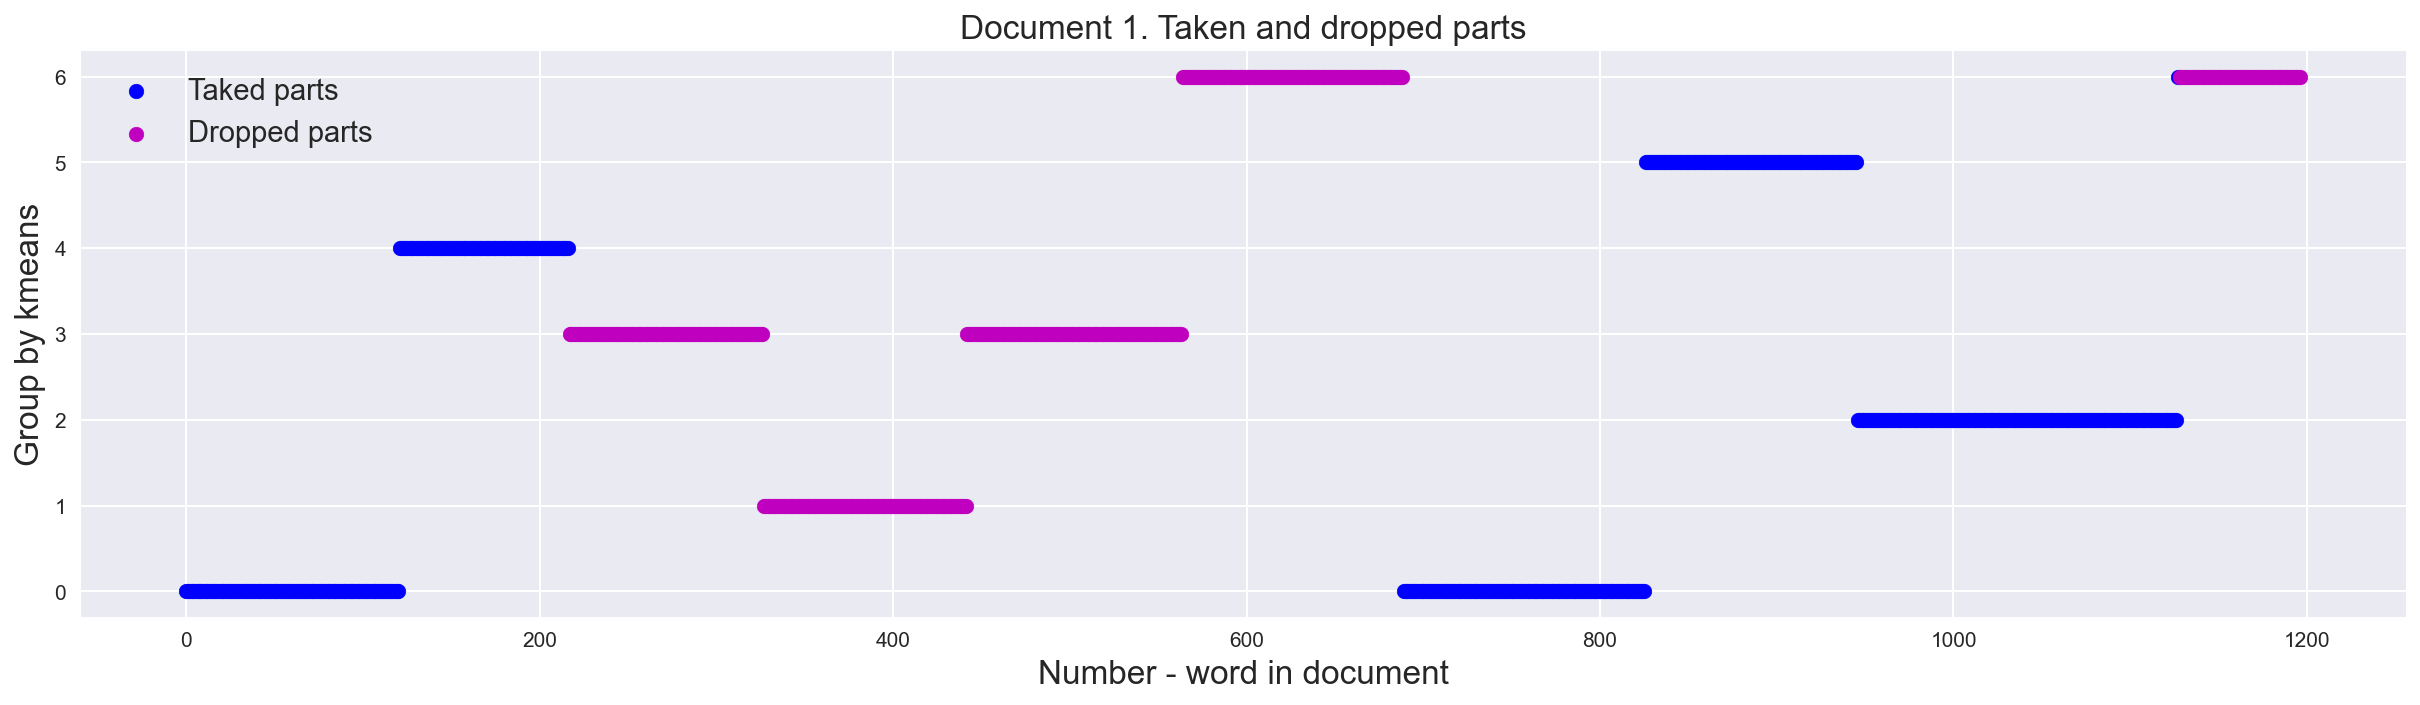

In [201]:
fig = plt.figure(figsize=(20, 5), dpi=150)
x = np.concatenate([np.arange(best_parts[0][0][0], best_parts[0][0][1]+1), np.arange(best_parts[0][1][0], best_parts[0][1][1]+1)])
plt.scatter(x=x, y=data[0]['labels'][x], color='b', label='Taked parts')
x2 = np.concatenate([np.arange(best_parts[0][0][1]+1, best_parts[0][1][0]), np.arange(best_parts[0][1][1]+1, data[0]['labels'].shape[0])])
plt.scatter(x=x2, y=data[0]['labels'][x2], color='m', label='Dropped parts')
plt.xlabel('Number - word in document', fontsize=16)
plt.ylabel('Group by kmeans', fontsize=16)
plt.legend(fontsize=14); plt.title('Document 1. Taken and dropped parts', fontsize=16);plt.show()

# step 4
make video

## Unfortunately, this part does not work because of the library for downloading videos from YouTube.
>__HTTPError: HTTP Error 410: Gone__

## building video file

In [ ]:
make_clip(file_names, file_len)